### Import the Libraries

In [1]:
import os
import math
import pandas as pd
import numpy as np

import librosa
import librosa.display

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow.keras as keras
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.python.keras import regularizers

data_path = '../audio_data_MFCC/6_segs_per_track_output.npz'

### Load and prepare the data

In [2]:
def load_data (dataset_path, data1 = 'mfcc', data2 = 'labels'):
    
    np_file = np.load(dataset_path)
    
    return np_file[data1], np_file[data2]

In [3]:
def prepare_datasets(data_path, test_size, validation_size):
    
    # load data
    X, y = load_data(data_path, 'mfcc', 'labels')
    
    # create train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    
    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, 
                                                                    y_train, 
                                                                    test_size=validation_size)
    
    
    X_train = X_train[..., np.newaxis] # 4d array -> (num_samples, 130, 13, 1)
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test
    

In [4]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets('../../audio_data_MFCC/6_segs_per_track_output.npz', 0.25, 0.2)

### Define and build the model

In [5]:
### Import the necessary layers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten

In [6]:
def build_model(input_shape):

    model = Sequential()

    # 1st Convulational Layer
    model.add(Conv2D(64, (5, 5), activation='relu', input_shape = input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # 2nd Convulational Layer
    model.add(Conv2D(64, (3, 3), activation ='relu'))
    model.add(MaxPooling2D((3, 3), strides = (2, 2), padding='same'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    
    # 3rd Convulational Layer
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    
    # Flatten the output
    model.add(keras.layers.Flatten())
    
    # Feed it to the dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.25))

    # Output Layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    return model

In [7]:
X_train.shape

(3595, 216, 13, 1)

### Build and Compile The Model

In [8]:
# Build the CNN
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

In [9]:
# Begin Compiling
optimizer = keras.optimizers.Adam(learning_rate = 0.00015)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Add in an early stop to avoid overtraining

In [10]:
early_stop = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=25)

In [11]:
history = model.fit(X_train, 
          y_train, 
          validation_data = (X_validation, y_validation), 
          batch_size = 64, 
          epochs = 100,
          callbacks = [early_stop]         
          )

Epoch 1/100
57/57 [==============================] - 12s 187ms/step - loss: 2.6221 - accuracy: 0.1789 - val_loss: 2.7890 - val_accuracy: 0.2225
Epoch 2/100
57/57 [==============================] - 9s 156ms/step - loss: 1.9792 - accuracy: 0.3460 - val_loss: 1.9612 - val_accuracy: 0.3126
Epoch 3/100
57/57 [==============================] - 15s 261ms/step - loss: 1.6995 - accuracy: 0.4162 - val_loss: 1.6347 - val_accuracy: 0.3971
Epoch 4/100
57/57 [==============================] - 17s 291ms/step - loss: 1.5618 - accuracy: 0.4590 - val_loss: 1.3815 - val_accuracy: 0.4805
Epoch 5/100
57/57 [==============================] - 17s 302ms/step - loss: 1.4526 - accuracy: 0.4910 - val_loss: 1.2597 - val_accuracy: 0.5406
Epoch 6/100
57/57 [==============================] - 16s 275ms/step - loss: 1.3549 - accuracy: 0.5117 - val_loss: 1.2373 - val_accuracy: 0.5539
Epoch 7/100
57/57 [==============================] - 14s 248ms/step - loss: 1.3293 - accuracy: 0.5311 - val_loss: 1.1598 - val_accuracy: 

In [12]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

47/47 [==============================] - 1s 27ms/step - loss: 0.8100 - accuracy: 0.7323 0s - loss: 0.8


### Plot

In [13]:
def plot_history(history):
    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Eval")

    # create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error Eval")

    plt.show()

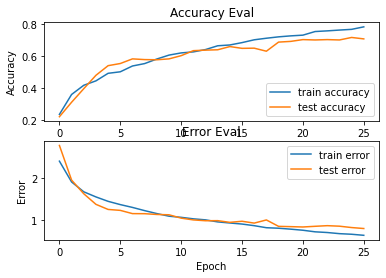

In [14]:
plot_history(history)

### Predict

In [15]:
predictions = model.predict(X_test, verbose = 1)

47/47 [==============================] - 2s 28ms/step


### Confusion Matrix

In [16]:
### Check the number of predicted values in each class, and append it to the labels_pred list
labels_pred = []
for i in range(10):
    
    print(f'{i}: {sum([1 for prediction in predictions if np.argmax(prediction) == i]) / 1000}')
    labels_pred.append(sum([1 for prediction in predictions if np.argmax(prediction) == i]) / 1000)

0: 0.21
1: 0.127
2: 0.155
3: 0.115
4: 0.138
5: 0.106
6: 0.147
7: 0.149
8: 0.237
9: 0.114


In [17]:
### Create a genre list 
genre_list = ['jazz:', 'reggae:', 'rock:', 'blues:', 'hiphop:', 'country:', 'metal:', 'classical:', 'disco:', 'pop:']


# Zip the results together
results = list(zip(genre_list, labels_pred))

# Sort them by second index
results = sorted(results, key = lambda x: x[1], reverse = True)

# Display the results of the predictionsfor i in results:
for i in results:
    print (' '.join(map(str, i)))

disco: 0.237
jazz: 0.21
rock: 0.155
classical: 0.149
metal: 0.147
hiphop: 0.138
reggae: 0.127
blues: 0.115
pop: 0.114
country: 0.106


### Save the Model

In [18]:
model.save('../models/cnn_model_6_segs_per_track.h5')

### Additional Prediction Stuff

In [22]:
def predict(model, X_prediction, y_prediction):
    
    X_prediction = X_prediction[np.newaxis, ...]
    
    # Plot predictions to a 2D Array
    predictions = model.predict(X_prediction)
    
    predicted_index = np.argmax(predictions, axis=1)
    
    
    print(f'Target: {y_prediction}, Predicted label: {predicted_index}')

In [23]:
X_prediction = X_test[100]
y_prediction = y_test[100]

In [24]:
pred = predict(model, X_prediction, y_prediction)

Target: 0, Predicted label: [0]
